In [1]:
from skimage.io import imread
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
%matplotlib notebook
import matplotlib.pyplot as plt
from utils.multi_slice_viewer import multi_slice_viewer
import os
import numpy as np
from scipy.spatial import Delaunay, Voronoi
import pandas as pd
from skimage.measure import regionprops_table

### Primary functions

#### Shape based feature extractor. This is the primary feature extractor used to grab geometric features from segmented nuclei. The properties from each labeled nuclei is output as a pandas dataframe for convenience. 

In [2]:


def getObjectProperties(labeled_image):
    
    """
    Returns labeled object properties in a pandas DataFrame for convienient sorting.
    
    
    Parameters 
    ----------
    
    labled_image : 3D numpy array
        Segmented image of nuclei where each individual object has been assigned a 
        unique integer idea.
        
    
    Returns
    -------
    
    object_props : pd.DataFrame
        DataFrame object with selected properties extracted using skimage.measure.regionprops_table
    
    
    
    """
    
    #object properties for extraction
    properties=[ 'equivalent_diameter', 'inertia_tensor',
                'inertia_tensor_eigvals', 'major_axis_length',
                'minor_axis_length', 'moments',
                'moments_central', 'label', 'area',
                'solidity', 'feret_diameter_max',
                'moments_normalized', 'centroid', 'bbox', 
                'bbox_area', 'extent',
                'convex_area', 'convex_image']
    
    #extract features and return as dataframe
    object_props = pd.DataFrame(regionprops_table(labeled_image,properties=properties))
    return object_props

#### Centroid reorganization - graph based features are constructed using a set of nodes, in this case the centroids of segmented nuclei. This method reorganizes the centroids and labels extracted from the above method into a 4D array. The array is the entire set of 3D points corresponding to centroid location of segmented nuclei in the labeled image. 

In [3]:
def getCentroids(proptable):
    
    """
    Returns labeled object centroids and labels in a dictionary.
    
    
    Parameters 
    ----------
    
    proptable : pd.DataFrame
        labeled object properties with centroid & label columns
    
    
    Returns
    -------
    
    props_dict : dict
        Dictionary with 'centroids' and 'labels' as keys, with corresponding
    centroids and labels extracted from proptable as numpy arrays.
    """
    
    props_dict = {}
    
    #get centroid column titles
    filter_col = [col for col in proptable if col.startswith('centroid')]
    
    props_dict['centroids'] = proptable[filter_col].to_numpy().astype(int)
    props_dict['labels'] = proptable['label'].to_numpy()
    
    return props_dict

#### Graph based feature extraction - the following method extracts graph based features (Delaunay & Voronoi diagrams) using the set of nuclear centroids as the input.

In [4]:

def getTesselations(centroids):
    
    """
    Return two graph based features from the scipy.spatial module
    
    
    Parameters
    ----------
    
    centroids : numpy array
        Array of centroids extracted from segmented nuclei
        
        
    Returns
    -------
    
    tesselD : scipy.spatial.Delaunay
        Fully connected graph based feature where nuclear centroids are
    input as nodes on the graph.
    
    tesselV : scipy.spatial.Voronoi
        Region based graph (derived from Delaunay) where individual regions
    are grown from points i.e nuclear centroids.
    
    """
    
    #extract delaunay diagram from scipy.spatial 
    tesselD = Delaunay(centroids)
    
    #extract voronoi diagram from scipy.spatial
    tesselV = Voronoi(centroids)
    
    return tesselD, tesselV
    

In [ ]:
def cropImage(image, image_props, object_label, clean=False):
    """
    crops section of input image based on bounding box of labeled objects

    labeled objects are determined by the object_label which is a label in a
    property table
    
    
    Parameters
    ----------
    
    image : 3D numpy array
        labeled segmented image of nuclei
        
    image_props : pd.DataFrame
        pandas dataframe of properties with label and bbox as extracted features
        
    object_label : int
        label of object to crop from input image
        
    clean : bool, optional
        clear objects without input label
        
    
    Returns
    -------
    
    crop : 3D numpy array
        cropped region containing the labeled object, crop coordinates are 
    based on the bounding box.

    """

    assert(type(object_label) == int)

    prop = image_props.loc[image_props['label'] == object_label]

    if len(image.shape) == 2:
        coords = [prop['bbox-0'].values[0], prop['bbox-2'].values[0], 
                  prop['bbox-1'].values[0], prop['bbox-3'].values[0]]
        print(coords)

        crop = copy.deepcopy(image[coords[0]:coords[1], coords[2]:coords[3]])

    else:
        coords = [prop['bbox-0'].values[0], prop['bbox-3'].values[0], 
                  prop['bbox-1'].values[0], prop['bbox-4'].values[0],
                  prop['bbox-2'].values[0], prop['bbox-5'].values[0]]
        crop = copy.deepcopy(image[coords[0]:coords[1],
                             coords[2]:coords[3],
                             coords[4]:coords[5]])

    if clean:
        crop = np.ma.masked_where(crop != object_label, crop).filled(0)
        crop = (crop > 0).astype(int)
    return crop

### Load example labeled 3D data from disk

In [5]:
data_file = os.path.join('./data/region1_3D_crop.tif')
data = imread(data_file)

### Display 3D data using multi-slice-viewer (use j & k keys to pan through volume)

<IPython.core.display.Javascript object>


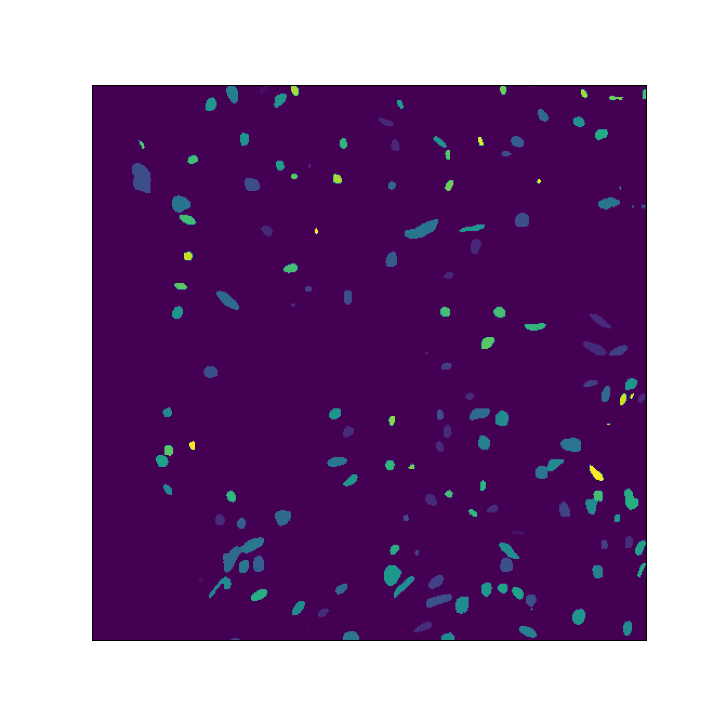

In [6]:
multi_slice_viewer(data, figsize= (8,8))

### Extract shape based features

In [7]:


data = remove_small_objects(data, min_size=150)

properties = getObjectProperties(data)

In [8]:
min(properties['area'])

151

<IPython.core.display.Javascript object>


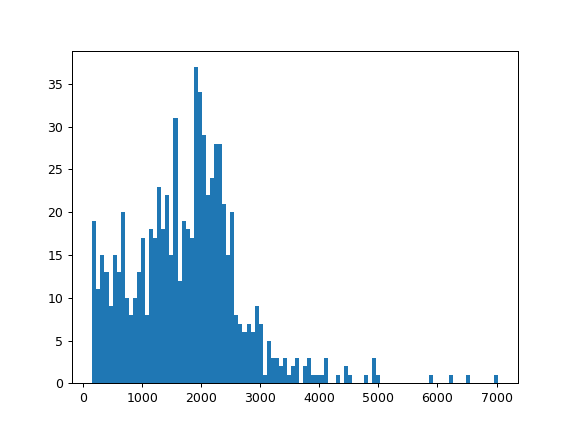

(array([19., 11., 15., 13.,  9., 15., 13., 20., 10.,  8., 10., 13., 17.,
         8., 18., 17., 23., 18., 22., 15., 31., 12., 19., 18., 17., 37.,
        34., 29., 22., 24., 28., 28., 21., 15., 20.,  8.,  7.,  6.,  7.,
         6.,  9.,  7.,  1.,  5.,  3.,  3.,  2.,  3.,  1.,  2.,  3.,  0.,
         2.,  3.,  1.,  1.,  1.,  3.,  0.,  0.,  1.,  0.,  2.,  1.,  0.,
         0.,  0.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 151.  ,  219.76,  288.52,  357.28,  426.04,  494.8 ,  563.56,
         632.32,  701.08,  769.84,  838.6 ,  907.36,  976.12, 1044.88,
        1113.64, 1182.4 , 1251.16, 1319.92, 1388.68, 1457.44, 1526.2 ,
        1594.96, 1663.72, 1732.48, 1801.24, 1870.  , 1938.76, 2007.52,
        2076.28, 2145.04, 2213.8 , 2282.56, 2351.32, 2420.08, 2488.84,
        2557.6 , 2626.36, 2695.12, 2763.88, 2832.64, 2901.4 , 2970.16,
        

In [9]:
plt.subplots()
plt.hist(properties['area'], bins = 100)

<IPython.core.display.Javascript object>


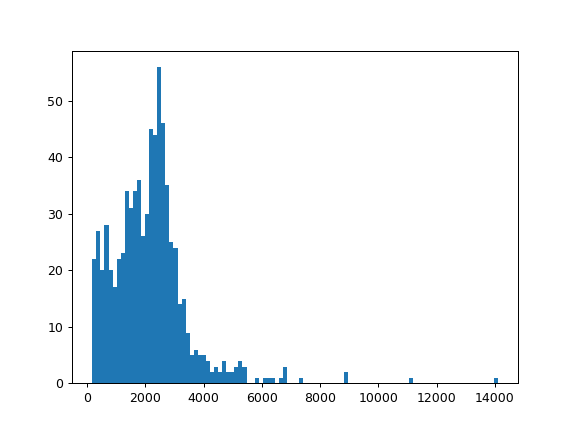

(array([22., 27., 20., 28., 20., 17., 22., 23., 34., 31., 34., 36., 26.,
        30., 45., 44., 56., 46., 35., 25., 24., 14., 15.,  9.,  5.,  6.,
         5.,  5.,  4.,  2.,  3.,  2.,  4.,  2.,  2.,  3.,  4.,  3.,  0.,
         0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  3.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  172.  ,   311.45,   450.9 ,   590.35,   729.8 ,   869.25,
         1008.7 ,  1148.15,  1287.6 ,  1427.05,  1566.5 ,  1705.95,
         1845.4 ,  1984.85,  2124.3 ,  2263.75,  2403.2 ,  2542.65,
         2682.1 ,  2821.55,  2961.  ,  3100.45,  3239.9 ,  3379.35,
         3518.8 ,  3658.25,  3797.7 ,  3937.15,  4076.6 ,  4216.05,
         4355.5 ,  4494.95,  4634.4 ,  4773.85,  4913.3 ,  5052.75,
         5192.2 ,  5331.65

In [10]:
plt.subplots()
plt.hist(properties['convex_area'], bins = 100)

### Collect nuclear centroids

In [11]:
centroids = getCentroids(properties)

### Extract graph-based tesselations

In [12]:
tesselD, tesselV = getTesselations(centroids['centroids'])